# Trabajo Práctico - NLP: Análisis de Sentimientos en Comentarios de YouTube

**Dataset:** MrBeast YouTube Comment Sentiment Analysis

## Dataset

In [377]:
import kagglehub
import pandas as pd
import numpy as np
import os
import seaborn as sns

# Descargar dataset
path = kagglehub.dataset_download("adilshamim8/mrbeast-youtube-comment-sentiment-analysis")

# Cargar el CSV
csv_path = os.path.join(path, "sentiment_analysis_dataset.csv")
#"Se utilizó on_bad_lines='skip' durante la carga para omitir líneas con formato CSV corrupto 
# (líneas con más campos de los esperados). 
# Esto es necesario porque algunas líneas del dataset tienen comas adicionales mal escapadas
#  que rompen el formato CSV estándar."
df = pd.read_csv(csv_path, on_bad_lines='skip')  

print(f"\nDataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(df.head())


Dataset cargado: 6802 filas, 2 columnas
                                             Comment Sentiment
0       Achieving million views in days is dangerous  Positive
1  How many people here want to participate in su...   Neutral
2            Mrbeast is slowly turning into mrjigsaw  Negative
3      genuinely can't believe how dystopian this is  Negative
4  Have of the worlds smartest people compete in ...   Neutral


# Exploración

In [378]:
#¿Cómo se distribuye el target?
df['Sentiment'].value_counts()

Sentiment
Positive    4689
Neutral     2033
Negative      79
 Neutral       1
Name: count, dtype: int64

In [379]:
#¿Qué caracteres figuran en el corpus?

caracteres = {}
_ = df['Comment'].dropna().apply(lambda x: [caracteres.update({c: caracteres.get(c, 0) + 1}) for c in x.lower()])
caracteres = pd.Series(caracteres).sort_values(ascending=False)

caracteres.index

Index([' ', 'e', 't', 'o', 'a', 'i', 's', 'n', 'r', 'h', 'l', 'd', 'u', 'c',
       'y', 'm', 'g', 'w', 'p', 'b', 'f', 'v', '.', '!', 'k', ',', ''', 'j',
       'z', '’', 'x', '"', '?', ':', '$', 'q', '“', '-', '”', '…', ')', '<',
       '(', '/', '&', '=', '%', '~', '+', '—', '️', 'é', 'á', '¿', 'ü', 'ş',
       'ı', '`', '2', '‘', '*'],
      dtype='object')

In [380]:
#¿Qué presencia de caracteres especiales tenemos en el corpus?
alfanum = 'abcdefghijklmnopqrstuvwxyz0123456789 '
weird = [c for c in caracteres.index if c not in alfanum]

caracteres[caracteres.index.intersection(weird)]

.    2315
!    1993
,    1225
'     882
’     551
"     373
?     362
:     212
$     146
“     106
-     100
”      89
…      70
)      37
<      26
(      23
/      17
&      15
=      15
%      12
~      11
+      11
—       9
️       7
é       7
á       6
¿       4
ü       4
ş       4
ı       4
`       4
‘       3
*       1
dtype: int64

In [381]:
#¿Cuántos documentos tienen que caracteres raros?

weird_doc_frec = {}
_ = df['Comment'].dropna().apply(lambda x: [weird_doc_frec.update({w: weird_doc_frec.get(w, 0) + (1 if w in x else 0)}) for w in weird])
weird_doc_frec = pd.Series(weird_doc_frec).sort_values(ascending=False)

weird_doc_frec

.    1504
!     946
,     937
'     730
’     470
?     247
:     167
"     160
$      94
“      88
”      77
-      74
…      40
)      37
<      26
(      23
/      17
&      15
=      15
%      11
+      11
~       9
—       9
️       7
é       7
á       6
¿       4
ü       4
ş       4
ı       4
`       4
‘       3
*       1
dtype: int64

In [382]:
#¿Tenemos URL?
df['Comment'].str.contains('http').value_counts()

Comment
False    6797
Name: count, dtype: int64

In [383]:
#¿Tenemos saltos de linea?
df['Comment'].str.contains('\n').value_counts()

Comment
False    6797
Name: count, dtype: int64

In [384]:
#¿Tenemos HTML?
df['Comment'].apply(lambda x: '<' in str(x) and '>' in str(x)).value_counts()

Comment
False    6802
Name: count, dtype: int64

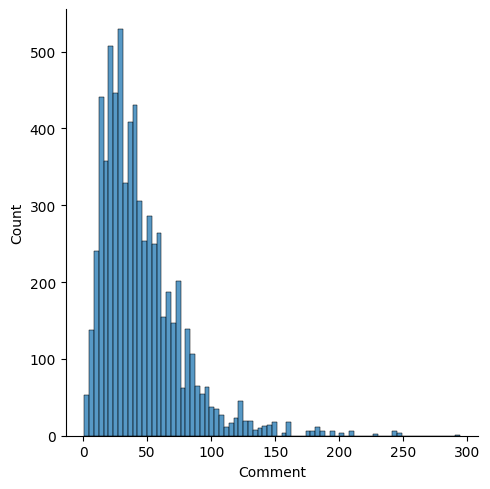

In [385]:
#¿Cuál es la longitud en caracteres de cada documento?
sns.displot(df['Comment'].str.len())

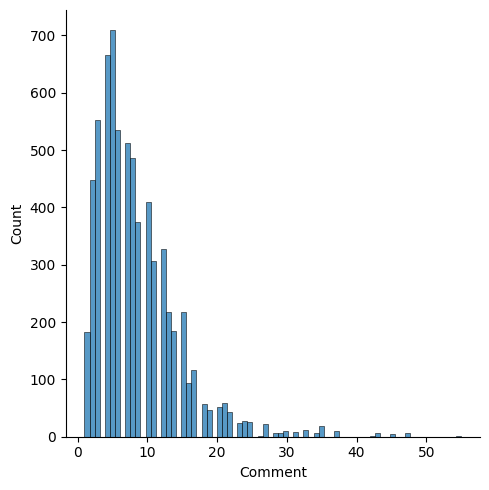

In [386]:
#¿Cuál es la longitud en palabras de cada documento?
sns.displot(df['Comment'].dropna().apply(lambda x: len(x.split())))

# Limpieza y Normalización

In [387]:
df['clean'] = df['Comment']

In [388]:
#Pasamos todo a minúscula
df['clean'] = df['clean'].str.lower()

In [389]:
#Eliminamos caracteres raros
df['clean'] = df['clean'].apply(lambda x: ''.join([c for c in str(x) if c in alfanum]))

In [390]:
#Eliminamos saltos de línea
df['clean'] = df['clean'].str.replace('\n', '')

In [391]:
#Eliminamos URL
df = df[~df['clean'].str.contains('http', na=False)]

In [392]:
#Eliminamos comentarios vacíos o solo con espacios
df = df[df['clean'].str.strip() != '']

#Comprobamos limpieza

In [393]:
# Chequeo minúsculas
df['clean'].apply(lambda x: str(x).islower()).value_counts()

clean
True    6798
Name: count, dtype: int64

In [394]:
#Chequeo caracteres raros
caracteres_clean = {}
_ = df['clean'].apply(lambda x: [caracteres_clean.update({c: caracteres_clean.get(c, 0) + 1}) for c in str(x)])
caracteres_clean = pd.Series(caracteres_clean).sort_values(ascending=False)

In [395]:
caracteres_clean.index

Index([' ', 'e', 't', 'o', 'a', 'i', 's', 'n', 'r', 'h', 'l', 'd', 'u', 'c',
       'y', 'm', 'g', 'w', 'p', 'b', 'f', 'v', 'k', 'j', 'z', 'x', 'q', '2'],
      dtype='object')

In [396]:
df_melt = df.melt(value_vars=['Comment', 'clean'], var_name='tipo', value_name='text')
df_melt['len_char'] = df_melt['text'].str.len()
df_melt['len_word'] = df_melt['text'].apply(lambda x: len(str(x).split()))

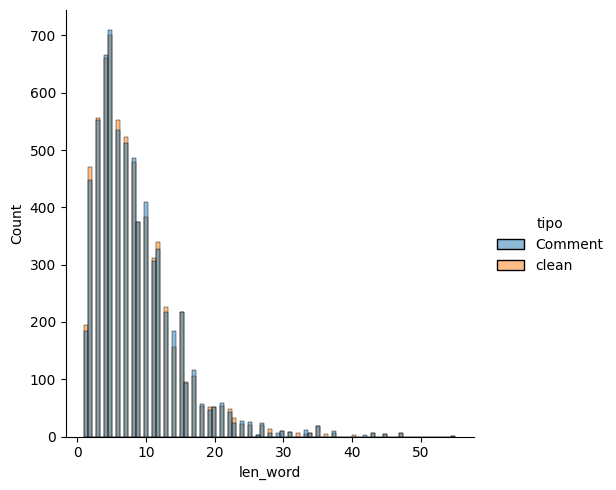

In [409]:
#¿Cuál es la longitud en palabras de cada documento?
sns.displot(df_melt, x='len_word', hue='tipo')

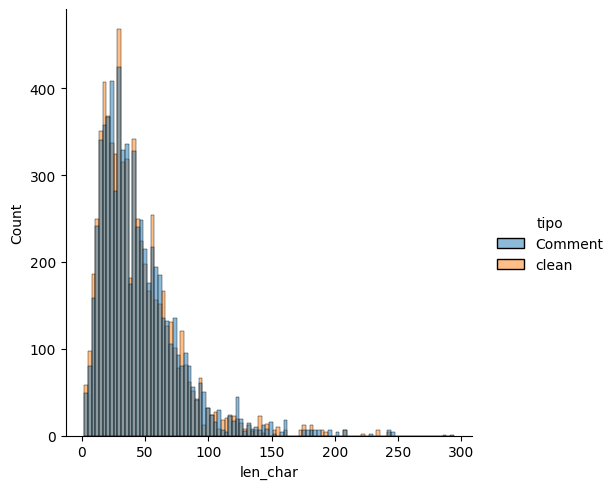

In [410]:
#¿Cuál es la longitud en caracteres de cada documento?
sns.displot(df_melt, x='len_char', hue='tipo')

In [397]:
clean_words = df['clean'].apply(lambda x: x.split()).explode().value_counts()

In [398]:
#¿Cuantas palabras diferentes hay?
clean_words.shape

(2232,)

In [399]:
#¿Cuantas palabras en total hay?
clean_words.sum()

np.int64(57056)

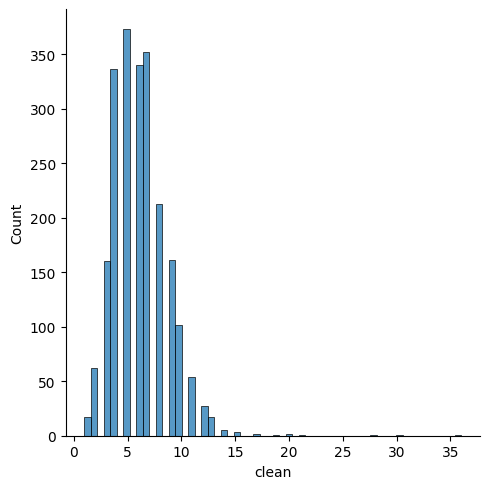

In [400]:
#¿Cuál es la longitud de las palabras?
sns.displot(x=clean_words.index.str.len())

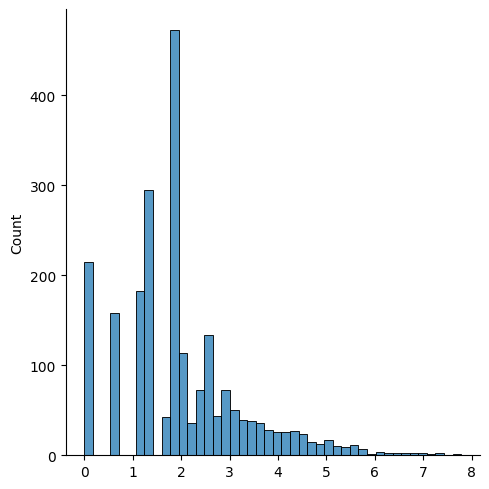

In [401]:
#¿Cual es la frecuencia de cada palabra?
sns.displot(x=np.log(clean_words.values))

In [402]:
#¿Tenemos palabras mal escritas? ¿Cuáles y cuantas?

!pip install pyspellchecker



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [403]:
from spellchecker import SpellChecker

eng = SpellChecker(language='en')

In [404]:
incorrectas = clean_words[clean_words.index.map(lambda x: x not in eng)]

In [405]:
incorrectas

clean
bro                     468
mrbeast                 189
im                      158
thats                   128
ive                     115
                       ... 
mvp                       1
behaviour                 1
homeruns                  1
badluck                   1
beastttttttttttttttt      1
Name: count, Length: 382, dtype: int64

In [406]:
incorrectas = incorrectas[incorrectas.index.str.len() > 4]

In [407]:
print(f'Hay un {round(incorrectas.sum() / clean_words.sum()*100)}% palabras potencialmente mal escritas')

Hay un 4% palabras potencialmente mal escritas
